### Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('News_Category_Dataset_v3.csv')

print(df.head())

   Unnamed: 0                                           headline   category  \
0           0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1           1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2           2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3           3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4           4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

         date  headline_length  short_description_length

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, correcting spelling, standardizing, handling contractions, and lemtization.

In [3]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

# clean data
df['cleaned_headline'] = df['headline'].apply(clean_text)
df['cleaned_description'] = df['short_description'].apply(clean_text)

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_20969/4207609330.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caoyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/caoyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1.3 Perform text tokenization and vectorization using TF-IDF.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

tfidf_vectorizer = TfidfVectorizer()

tfidf_headline = tfidf_vectorizer.fit_transform(df['cleaned_headline'])
# df_headline_tfidf = pd.DataFrame(tfidf_headline.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# df_headline_tfidf = df_headline_tfidf.add_prefix('headline_')

tfidf_description = tfidf_vectorizer.fit_transform(df['cleaned_description'])
# df_description_tfidf = pd.DataFrame(tfidf_description.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# df_description_tfidf = df_description_tfidf.add_prefix('description_')

# df = pd.concat([df, df_headline_tfidf, df_description_tfidf], axis=1)
tfidf= hstack([tfidf_headline,tfidf_description])

1.4 Extract and analyze different features from the text that might be useful for classification, such as word count,
sentence length, n-grams, etc

In [5]:
#pip install category_encoders

from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

# change date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# word count
df['headline_word_count'] = df['headline'].apply(lambda x: len(str(x).split()))
df['description_word_count'] = df['short_description'].apply(lambda x: len(str(x).split()))

# encode authors using Binary encoding
encoder = BinaryEncoder(cols=['authors'], return_df=True)
df_encoded = encoder.fit_transform(df['authors'])
df_encoded_sparse = csr_matrix(df_encoded.values)

# drop extra columns
selected_columns = ['year', 'month', 'day', 'headline_length', 'short_description_length', 'headline_word_count', 'description_word_count' ]
new_df = df[selected_columns].copy()
# combine
original_data = hstack([csr_matrix(new_df), df_encoded_sparse,tfidf])

# encode category using label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category']) # use for Logistic Regression, Random Forest, and XGBoost

y_categorical = pd.get_dummies(df['category']) # use for Artificial Neural Network and Convolutional Neural Network 

print(y)
print(y_categorical)
print(original_data)

[35 35  5 ... 28 28 28]
         ARTS  ARTS & CULTURE  BLACK VOICES  BUSINESS  COLLEGE  COMEDY  CRIME  \
0       False           False         False     False    False   False  False   
1       False           False         False     False    False   False  False   
2       False           False         False     False    False    True  False   
3       False           False         False     False    False   False  False   
4       False           False         False     False    False   False  False   
...       ...             ...           ...       ...      ...     ...    ...   
209522  False           False         False     False    False   False  False   
209523  False           False         False     False    False   False  False   
209524  False           False         False     False    False   False  False   
209525  False           False         False     False    False   False  False   
209526  False           False         False     False    False   False  False   

   

In [6]:
# Dimensionality Reduction using TruncatedSVD (which is better for sparse matrix)
from sklearn.decomposition import TruncatedSVD
import numpy as np

n_components = 100
svd = TruncatedSVD(n_components=n_components)

reduced_data = svd.fit_transform(original_data)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = sum(svd.explained_variance_ratio_)
print(f"Cumulative explained variance ratio with {n_components} components: {cumulative_explained_variance_ratio:.4f}")

Cumulative explained variance ratio with 100 components: 0.9998


In [7]:
import umap.umap_ as umap

# Create an instance of the UMAP model
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1,  n_components=2, metric='euclidean')

# Fit the model to your TF-IDF data and transform the data
reduced_data_umap = reducer.fit_transform(original_data)

/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-13 01:16:37.570126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Logistic Regression

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_test, pred, title):
	conf_matrix = confusion_matrix(y_test, pred)  # Use predictions_binary or the equivalent for your case
	plt.figure(figsize=(10, 7))
	sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Class1', 'Class2'], yticklabels=['Class1', 'Class2'])
	plt.xlabel('Predicted Labels')
	plt.ylabel('True Labels')
	plt.title(title)
	plt.show()
	print(conf_matrix)

# ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_scores, title):
	# Assuming you have n_classes classes
	n_classes = len(np.unique(y_test))  # Make sure true_labels is your array of true labels

	true_labels_binarized = label_binarize(y_test, classes=range(n_classes))

	fpr = dict()
	tpr = dict()
	roc_auc = dict()

	for i in range(n_classes):
		fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], y_scores)
		roc_auc[i] = auc(fpr[i], tpr[i])

	plt.figure(figsize=(7, 7))
	colors = ['blue', 'red', 'green', 'purple', 'orange']
	for i, color in zip(range(n_classes), colors):
		plt.plot(fpr[i], tpr[i], color=color, lw=2,
						 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

	plt.plot([0, 1], [0, 1], 'k--', lw=2)
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title(title)
	plt.legend(loc="lower right")
	plt.show()

In [15]:

#Logistic Regression: Use as a baseline model to understand the linear separability of text categories.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def perform_logistic(X, y):
	# Split the dataset into training and testing sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# Initialize the Logistic Regression model
	model = LogisticRegression(max_iter=1000)  # Increased iteration count to ensure convergence

	# Fit the model on the training data
	model.fit(X_train, y_train)

	# Make predictions on the test set
	y_pred = model.predict(X_test)
	return y_test, y_pred
	
def print_precision(y_test, y_pred):
	# Evaluate the model's performance
	accuracy = accuracy_score(y_test, y_pred)
	precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Handling division by zero for classes with no predictions
	recall = recall_score(y_test, y_pred, average='weighted')
	f1 = f1_score(y_test, y_pred, average='weighted')

	# Print the evaluation metrics
	print(f"Accuracy: {accuracy}")
	print(f"Precision: {precision}")
	print(f"Recall: {recall}")
	print(f"F1 Score: {f1}")

Try to run with original data, however, it costs 27minutes and doesn't get a result.

In [8]:
# y_ori, p_ori = perform_logistic(original_data, y)
# print_precision(y_ori, p_ori)

# Accuracy: 0.20939722235479405
# Precision: 0.07310446519118276
# Recall: 0.20939722235479405
# F1 Score: 0.09615892807364297

# Accuracy: The model correctly predicts 20.48%(max_iter=500)/20.93%(max_iter=1000) of the samples. This is a relatively low value, indicating that the model is not very good at correctly classifying data points in the test set overall.

# Precision: The weighted average precision is 6.67%(max_iter=500)/7.31%(max_iter=1000). Precision refers to the proportion of samples predicted as positive that are actually positive. This very low value indicates that only a small fraction of the samples predicted by the model as positive are correct.

# Recall: The weighted average recall is the same as accuracy, at 20.48%(max_iter=500)/20.93%(max_iter=1000). Recall calculates the proportion of samples that were predicted as positive and are actually positive out of all actual positive samples. This metric indicates the proportion of true positive samples the model is able to identify.

# F1 Score: The weighted average F1 score is 8.64%(max_iter=500)/9.61%(max_iter=1000). The F1 score is the harmonic mean of precision and recall, trying to provide a balance between the two. A low F1 score indicates a lack of balance between precision and recall, with poor performance in both.

KeyboardInterrupt: 

The perform with data reduced dimension by PCA runs quickly. It costs only 4minutes.

In [9]:
y_pca, p_pca = perform_logistic(reduced_data, y)
print_precision(y_pca, p_pca)

Accuracy: 0.21278575860258675
Precision: 0.09468086486817778
Recall: 0.21278575860258675
F1 Score: 0.10944585513016525


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


But the accuracy, precision, recall, and f1 score doesn't work well. There may be some key params I must find.

However, with a RandomizedSearchCV, there is no result after running 4 hours. I have to find a better solution.

Reducing the iteration to 100 from 1000, I get the answer after 2.5 hours execution. Our param space is:
```
param_space = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
```
The best params are: 
```
{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.3593813663804626}
```

In the 3 parameters, the most important one is the solver 'liblinear'. With the 'saga' solver all accuracy are around '0.22'.

The second important factor is C. C is a regularization strength inverse. The accuracy would be above 0.4 when C is from 0.046415888336127774 to 21.54434690031882, but when C is around 0.00077 the accuracy drops to 0.22 too.

Not sure the difference of l1 and l2.

liblinear takes a long time than saga.

In [8]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import ParameterSampler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from time import time, sleep

# # Define parameter space
# param_space = {
#     'C': np.logspace(-4, 4, 10),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# # Generate a list of parameter combinations
# param_list = list(ParameterSampler(param_space, n_iter=10, random_state=42))

# # Split your data
# X_train, X_val, y_train, y_val = train_test_split(reduced_data, y, test_size=0.2, random_state=42, stratify=y)

# results = []
# start_overall = time()

# for i, params in enumerate(param_list, 1):
#     start = time()
    
#     # Initialize and fit the model
#     model = LogisticRegression(**params, max_iter=100)
#     model.fit(X_train, y_train)
    
#     # Predict and evaluate
#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     # Log results
#     elapsed = time() - start
#     print(f"Iteration {i}/{len(param_list)}: Accuracy={accuracy:.4f}, Time={elapsed:.2f}s, Params={params}")
    
#     results.append((accuracy, params, elapsed))
    
#     # Estimated time left
#     avg_time_per_iter = (time() - start_overall) / i
#     est_time_left = avg_time_per_iter * (len(param_list) - i)
#     print(f"Estimated time left: {est_time_left:.2f}s")

# # Convert results to DataFrame for easier analysis
# results_df = pd.DataFrame(results, columns=['Accuracy', 'Params', 'Time'])
# print("Best result:", results_df.loc[results_df['Accuracy'].idxmax()])


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 1/10: Accuracy=0.2122, Time=331.19s, Params={'solver': 'saga', 'penalty': 'l2', 'C': 0.3593813663804626}
Estimated time left: 2980.73s


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 2/10: Accuracy=0.4641, Time=2649.60s, Params={'solver': 'liblinear', 'penalty': 'l1', 'C': 0.3593813663804626}
Estimated time left: 11923.17s


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 3/10: Accuracy=0.2122, Time=276.81s, Params={'solver': 'saga', 'penalty': 'l2', 'C': 0.046415888336127774}
Estimated time left: 7601.06s
Iteration 4/10: Accuracy=0.4313, Time=1981.18s, Params={'solver': 'liblinear', 'penalty': 'l2', 'C': 21.54434690031882}
Estimated time left: 7858.17s
Iteration 5/10: Accuracy=0.2269, Time=87.83s, Params={'solver': 'liblinear', 'penalty': 'l1', 'C': 0.000774263682681127}
Estimated time left: 5326.61s


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 6/10: Accuracy=0.4280, Time=1264.62s, Params={'solver': 'liblinear', 'penalty': 'l1', 'C': 0.046415888336127774}
Estimated time left: 4394.15s


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 7/10: Accuracy=0.2121, Time=933.62s, Params={'solver': 'saga', 'penalty': 'l1', 'C': 10000.0}
Estimated time left: 3224.94s


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 8/10: Accuracy=0.2122, Time=625.32s, Params={'solver': 'saga', 'penalty': 'l2', 'C': 21.54434690031882}
Estimated time left: 2037.54s


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 9/10: Accuracy=0.2122, Time=628.65s, Params={'solver': 'saga', 'penalty': 'l2', 'C': 10000.0}
Estimated time left: 975.42s
Iteration 10/10: Accuracy=0.2591, Time=781.58s, Params={'solver': 'liblinear', 'penalty': 'l2', 'C': 0.000774263682681127}
Estimated time left: 0.00s
Best result: Accuracy                                             0.464134
Params      {'solver': 'liblinear', 'penalty': 'l1', 'C': ...
Time                                              2649.600048
Name: 1, dtype: object


We applied above parameter into our model.

In [9]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_data, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', penalty='l1', C=0.3593813663804626, max_iter=100)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
print_precision(y_test, y_pred)

/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


It spends 51 minutes! A long time than I thought. No matter what, we now can get the confusion matrix and ROC curves.

In [16]:
print_precision(y_test, y_pred)

Accuracy: 0.4629885935188279
Precision: 0.4540103298645748
Recall: 0.4629885935188279
F1 Score: 0.4120746897248994


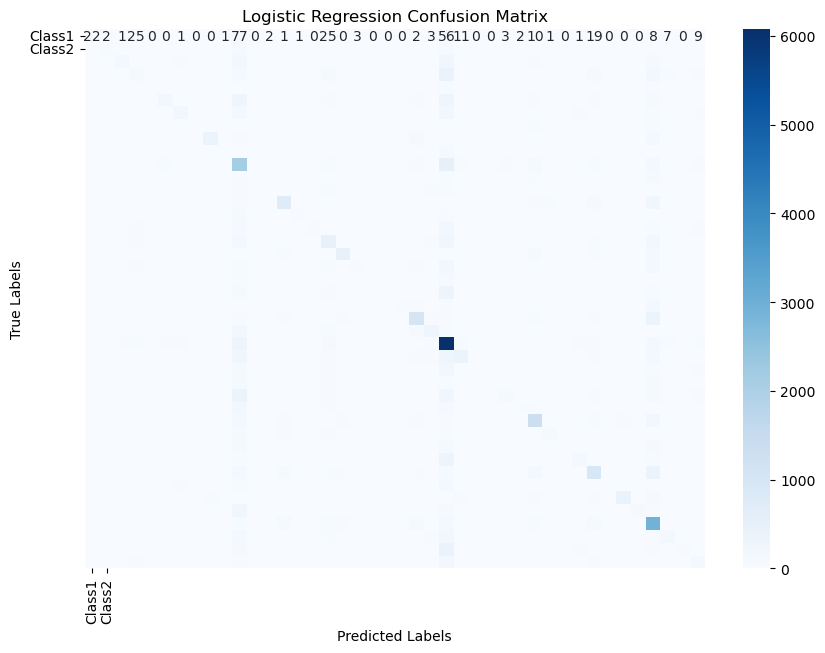

[[ 22   2   1 ...   7   0   9]
 [  0  69   2 ...   7   0   0]
 [  1   0 147 ...   7   1  23]
 ...
 [  0   2   2 ... 158   1   9]
 [  0   0   2 ...   9  27   0]
 [  3   0   4 ...   2   0 152]]


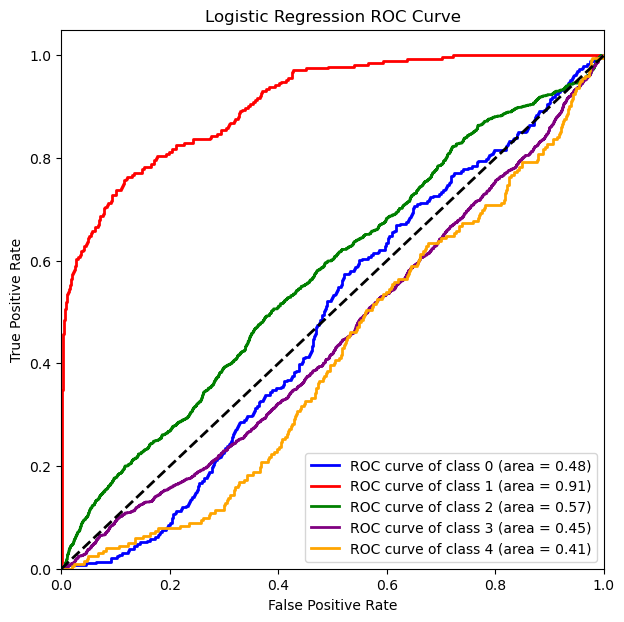

In [20]:
plot_confusion_matrix(y_test, y_pred, "Logistic Regression Confusion Matrix")
y_scores = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores, "Logistic Regression ROC Curve")